In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
import fingerprinting
from collections import defaultdict
from scipy.ndimage.filters import maximum_filter
import mysql.connector
import os
import os.path
import pydub

%matplotlib inline

In [2]:
cnx = mysql.connector.connect(user='root', password='webster',
                              host='127.0.0.1',
                              database='fprints')

In [3]:
cursor = cnx.cursor()

In [4]:
freq, rec = wavfile.read('data/Arcade Fire - Discography - 2001-2013/Albums (CD Original)/2004 - Funeral - (320 kbps)/01. Neighborhood 1 (Tunnels).wav')

In [5]:
def get_random_sample(song, time, freq=44100):
    sample_length = time*freq
    start = np.random.randint(0, len(song)-sample_length)
    return song[start:start+sample_length]

In [8]:
sample = get_random_sample(rec, 5)

In [9]:
Audio(sample[:], rate = freq)

In [12]:
select_fprint = ("SELECT offset, song_id FROM fingerprints WHERE hash = %s;")
select_song = ("SELECT songname FROM songnames WHERE song_id = %s")

def recognize(recording, cursor):
    rec_fprint_gen = fingerprinting.gen_fingerprint(recording)
    
    results = {}
    max_id = 0
    max_offset_count = 0
    for fprint in rec_fprint_gen:
        cursor.execute(select_fprint, (fprint[0][:10],))
        for (offset, song_id) in cursor:
            global_offset = int(fprint[1]) - offset
            if song_id in results.keys():
                if global_offset in results[song_id].keys():
                    results[song_id][global_offset] += 1
                    if results[song_id][global_offset] > max_offset_count:
                        max_id = song_id
                        max_offset_count = results[song_id][global_offset]
                else:
                    results[song_id][global_offset] = 1
            else:
                results[song_id] = {global_offset: 1}
    cursor.execute(select_song, (max_id,))
    songname = []
    for s in cursor:
        songname.append(s)
    return songname, results[max_id]

#### Let's check how is it able to recognize clean audiotracks

In [24]:
songname, bins = recognize(sample, cursor)
songname[0], max(bins.values())

(('01. Neighborhood 1 (Tunnels)',), 230)

In [63]:
def get_noisy(signal, snr):
    noise = np.random.normal(0,1,len(signal))
    s_power = sum(abs(signal/1000)**2)/len(signal) * 1000000
    n_power = sum(abs(noise)**2)/len(noise)
    K = (s_power/n_power)*10**(-snr/10)
    return signal + np.sqrt(K)*noise

#### SNR 5 recognition

In [79]:
noised_sample = get_noisy(sample, -15)
Audio(noised_sample[:], rate = freq)

In [57]:
songname, bins = recognize(noised_sample, cursor)
songname[0], max(bins.values())

(('01. Neighborhood 1 (Tunnels)',), 6)

##### Number of right matchings is extremely lower

#### Let's check what happens if we put a song that was not fingerprinted

In [ ]:
freq, rec = wavfile.read('data/recordings/rdings/rec2_ultralight.wav')
rec = np.sum(np.asarray(rec), axis=1)

In [70]:
for i in cursor:
    pass

In [80]:
def test_recognition(n_songs, sample_length, snr):
    i = 0
    n_correct = 0
    bin_max = []
    for dirpath, dirnames, filenames in os.walk("data/"):
        for filename in [f for f in filenames if f.endswith(".wav")]:
            full_path = os.path.join(dirpath, filename)
            samp_freq, song = wavfile.read(full_path)
            if samp_freq != 44100 or isinstance(song[0], list):
                continue
            i+=1
            sample = get_noisy(get_random_sample(song, sample_length), snr)
            songname, bins = recognize(sample, cursor)
            if songname[0][0] == filename[:-4]:
                n_correct += 1
            bin_max.append(max(bins.values()))
            if i >= n_songs:
                return n_correct/n_songs, bin_max

In [81]:
correct, bins_max = test_recognition(10, 10, 10)

In [85]:
SNRs = np.linspace(-12, 12, 9)

In [86]:
n_test_songs=20
correct_5s = []
bins_max_5s = []
for snr in SNRs:
    c, b = test_recognition(n_test_songs, 5, snr)
    correct_5s.append(c)
    bins_max_5s.append(b)

In [88]:
correct_10s = []
bins_max_10s = []
for snr in SNRs:
    c, b = test_recognition(n_test_songs, 10, snr)
    correct_10s.append(c)
    bins_max_10s.append(b)

In [89]:
correct_15s = []
bins_max_15s = []
for snr in SNRs:
    c, b = test_recognition(n_test_songs, 15, snr)
    correct_15s.append(c)
    bins_max_15s.append(b)

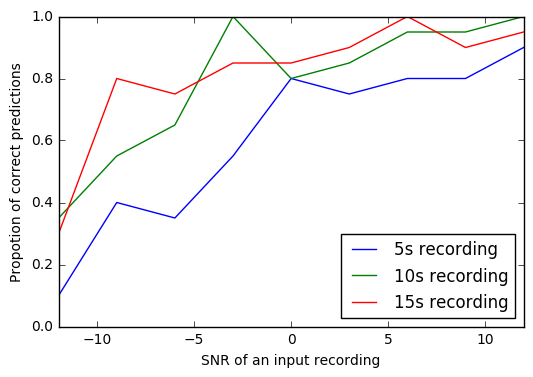

In [97]:
plt.plot(SNRs, correct_5s, label='5s recording');
plt.plot(SNRs, correct_10s, label='10s recording');
plt.plot(SNRs, correct_15s, label='15s recording');
plt.legend(loc=4)
plt.xlim(-12, 12)
plt.xlabel('SNR of an input recording')
plt.ylim(0, 1)
plt.ylabel('Propotion of correct predictions');

In [109]:
b_5s = [max(b) for b in bins_max_5s]
b_10s = [max(b) for b in bins_max_10s]
b_15s = [max(b) for b in bins_max_15s]

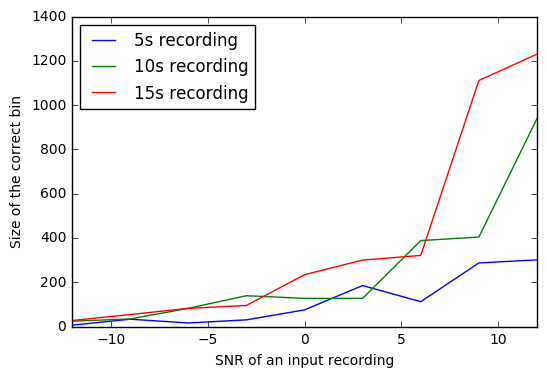

In [112]:
plt.plot(SNRs, b_5s, label='5s recording');
plt.plot(SNRs, b_10s, label='10s recording');
plt.plot(SNRs, b_15s, label='15s recording');
plt.legend(loc=2)
plt.xlim(-12, 12)
plt.xlabel('SNR of an input recording')
# plt.ylim(0, 1)
plt.ylabel('Size of the correct bin');

In [113]:
import hashlib